# EDA for X-ray Hand Semantic Segmentation
This notebook performs exploratory data analysis on the X-ray hand dataset for a semantic segmentation task involving 29 bones. The data includes images of left and right hands for each person, with corresponding annotations in JSON format.

The notebook covers:
- Basic dataset overview
- Class distribution analysis
- Image and mask visualization
- Intensity distribution in X-ray images
- Data augmentation examples


In [1]:

import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from PIL import Image
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast, Compose
from itertools import combinations

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

# Define dataset paths
data_dir = '/data/ephemeral/home/data/train/DCM'
annotation_dir = '/data/ephemeral/home/data/train/outputs_json'
image_paths = sorted(glob(os.path.join(data_dir, 'ID*/*.png')))
annotation_paths = sorted(glob(os.path.join(annotation_dir, 'ID*/*.json')))

print(f"Total images: {len(image_paths)}")
print(f"Total annotations: {len(annotation_paths)}")


Total images: 800
Total annotations: 800


### 이미지와 Annotation 출력 

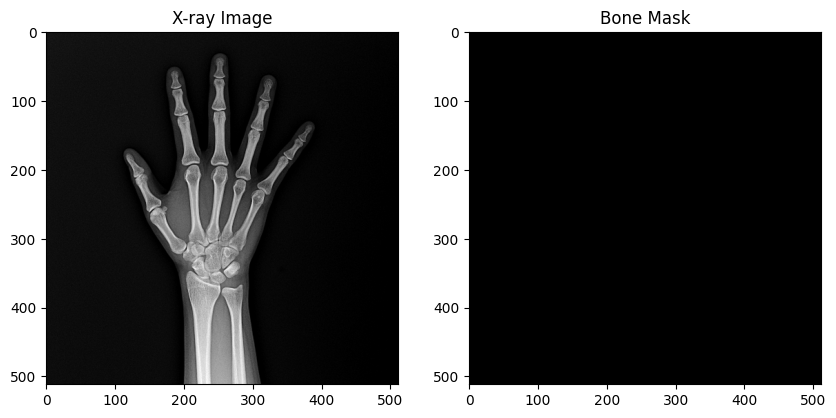

In [3]:
def display_image_and_annotations(image_path, annotation_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    image = cv2.resize(image, (512, 512))
    
    # Initialize mask
    mask = np.zeros_like(image)
    
    # Load annotation and create mask
    try:
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON at {annotation_path}")
        return

    # Draw each polygon for bones
    try:
        for bone in annotation_data['annotations']:
            # Extract and reshape points for cv2.fillPoly
            points = np.array(bone['points'], dtype=np.int32)
            if points.size > 0:  # Ensure there are points to draw
                points = points.reshape((-1, 1, 2))  # Reshape for cv2.fillPoly
                cv2.fillPoly(mask, [points], 255)
    except KeyError as e:
        print(f"Error: Missing expected key in JSON data - {e}")
        return

    # Display image and mask
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('X-ray Image')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Bone Mask')
    plt.show()

# Display sample
display_image_and_annotations(image_paths[0], annotation_paths[0])


### 각 클래스별 수

100%|██████████| 800/800 [00:04<00:00, 185.95it/s]


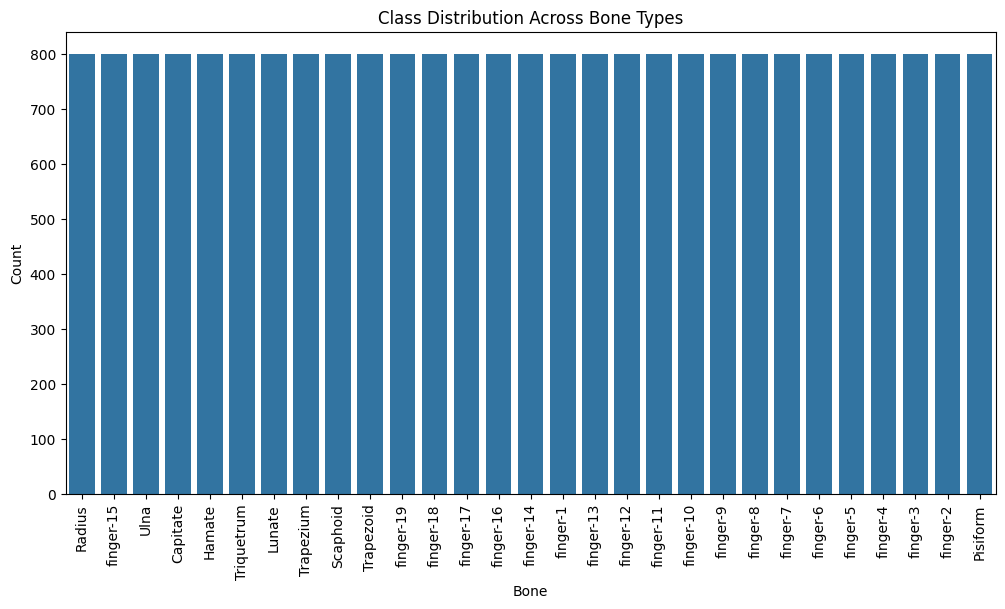

In [4]:

# Calculate class distribution
class_counts = {}
for ann_path in tqdm(annotation_paths):
    with open(ann_path, 'r') as f:
        data = json.load(f)
    for bone in data['annotations']:
        label = bone['label']
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Display class distribution
class_df = pd.DataFrame(list(class_counts.items()), columns=['Bone', 'Count']).sort_values(by='Count', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=class_df, x='Bone', y='Count')
plt.xticks(rotation=90)
plt.title("Class Distribution Across Bone Types")
plt.show()


### 이미지의 intensity 를 통한 EDA

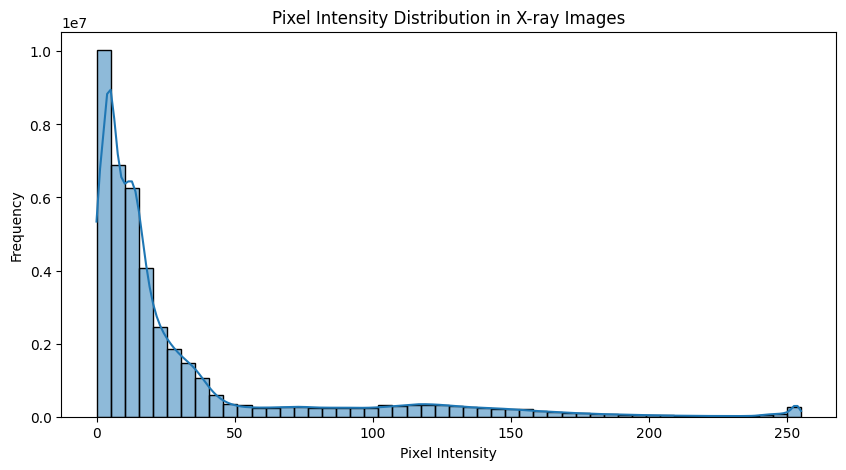

In [5]:

# Sample pixel intensity distribution
sample_images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in image_paths[:10]]
all_pixels = np.concatenate([img.flatten() for img in sample_images])

plt.figure(figsize=(10, 5))
sns.histplot(all_pixels, bins=50, kde=True)
plt.title("Pixel Intensity Distribution in X-ray Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


### 이미지에 intensity 범위별 시각화

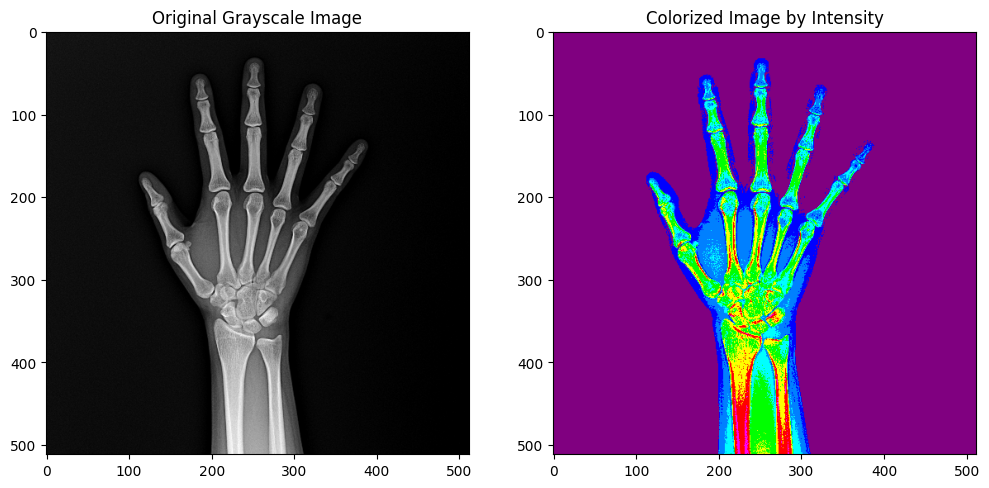

In [6]:
def colorize_intensity(image, bins, colors):
    """
    Colorize image based on intensity levels.
    - image: Grayscale input image (2D array).
    - bins: List of intensity boundaries to categorize.
    - colors: List of colors to apply for each intensity bin.
    """
    # Convert grayscale to BGR
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(len(bins) - 1):
        # Define mask for current intensity range
        mask = cv2.inRange(image, bins[i], bins[i+1] - 1)
        # Apply color to current intensity range
        color_image[mask > 0] = colors[i]

    return color_image

# Load and resize sample image
image_path = image_paths[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512, 512))

# Define intensity bins and corresponding colors (in BGR format)
bins = [0, 32, 64, 96, 128, 160, 192, 224, 256]
colors = [
    (128, 0, 128),  # Purple for lowest intensity
    (0, 0, 255),    # Red
    (0, 128, 255),  # Orange
    (0, 255, 255),  # Yellow
    (0, 255, 0),    # Green
    (255, 255, 0),  # Cyan
    (255, 0, 0),    # Blue
    (255, 0, 255),  # Magenta for highest intensity
]

# Colorize image
colorized_image = colorize_intensity(image, bins, colors)

# Display original and colorized images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[1].imshow(colorized_image)
axes[1].set_title('Colorized Image by Intensity')
plt.show()

### 이미지에 intensity 범위별 시각화2

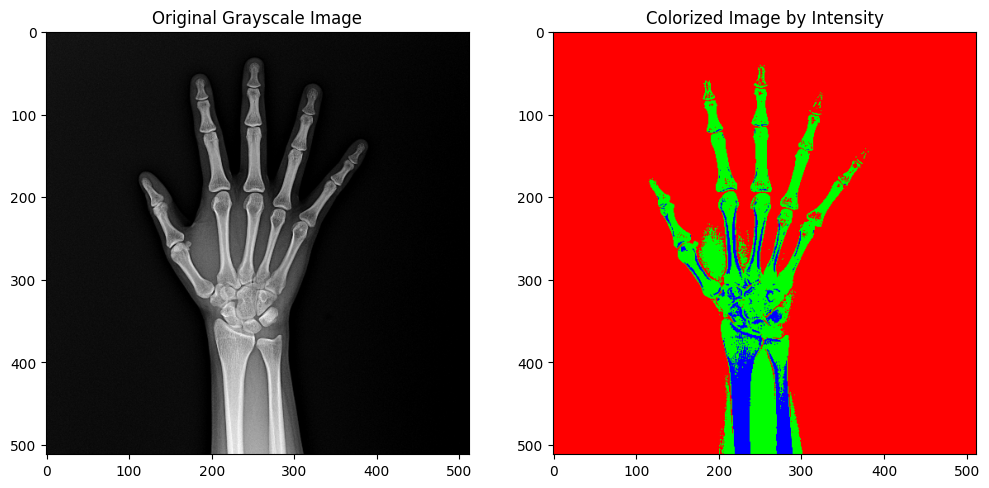

In [7]:
def colorize_intensity(image, bins, colors):
    """
    Colorize image based on intensity levels.
    - image: Grayscale input image (2D array).
    - bins: List of intensity boundaries to categorize.
    - colors: List of colors to apply for each intensity bin.
    """
    # Convert grayscale to BGR
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(len(bins) - 1):
        # Define mask for current intensity range
        mask = cv2.inRange(image, bins[i], bins[i+1])
        # Apply color to current intensity range
        color_image[mask > 0] = colors[i]

    return color_image

# Load and resize sample image
image_path = image_paths[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512, 512))

# Define intensity bins and corresponding colors (in BGR format)
bins = [0, 85, 170, 255]  # Example: low, medium, high intensity ranges
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Blue, Green, Red for each range

# Colorize image
colorized_image = colorize_intensity(image, bins, colors)

# Display original and colorized images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[1].imshow(colorized_image)
axes[1].set_title('Colorized Image by Intensity')
plt.show()

### 각 클래스별 뼈 면적 픽셀수와 비율

                                               Image     Class  Pixel Area  \
0  /data/ephemeral/home/data/train/DCM/ID001/imag...    Radius     75188.0   
1  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-1      6201.0   
2  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-2     14075.0   
3  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-3     22104.0   
4  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-4      4456.0   

      Ratio  
0  0.017926  
1  0.001478  
2  0.003356  
3  0.005270  
4  0.001062  


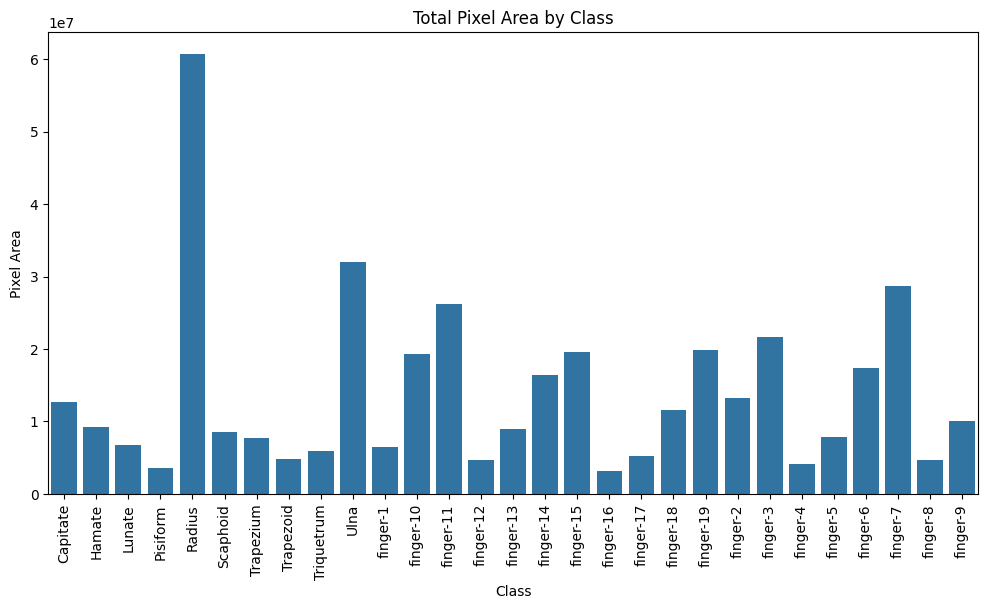

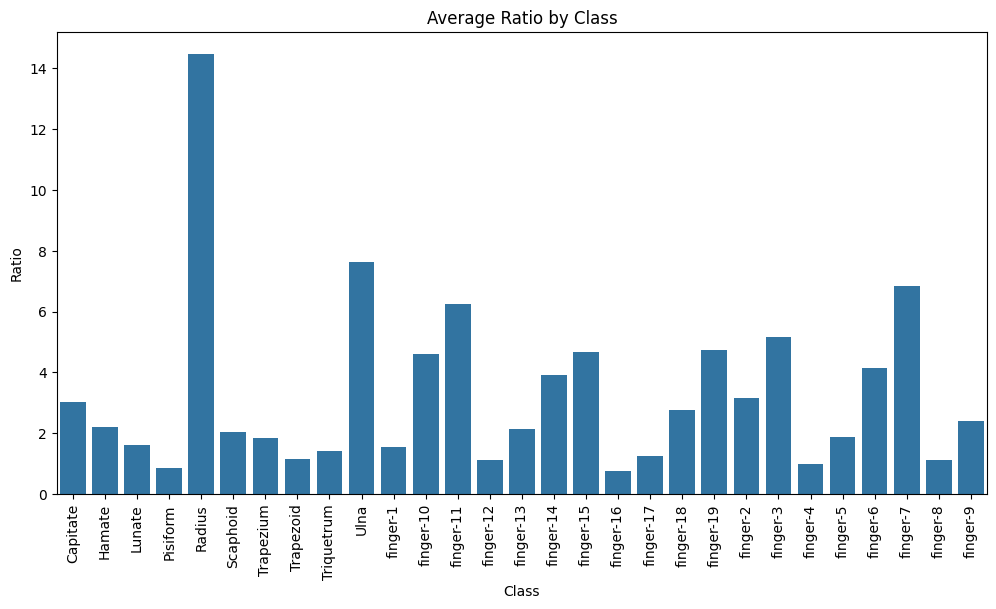

In [8]:
# Function to calculate pixel area and ratio for each class in an image
def calculate_pixel_area_ratio(image_path, annotation_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    
    image_area = image.shape[0] * image.shape[1]
    class_areas = {}

    for bone in data['annotations']:
        label = bone['label']
        mask = np.zeros_like(image, dtype=np.uint8)
        
        # Using the 'points' key to get polygon points for each annotation
        cv2.fillPoly(mask, [np.array(bone['points'], dtype=np.int32)], 1)
        class_pixel_count = np.sum(mask)

        if label not in class_areas:
            class_areas[label] = {'pixel_area': 0, 'ratio': 0.0}
        
        class_areas[label]['pixel_area'] += class_pixel_count
        class_areas[label]['ratio'] = class_areas[label]['pixel_area'] / image_area
    
    return class_areas

# Apply to all images and gather results
results = []
for image_path, ann_path in zip(image_paths, annotation_paths):
    class_areas = calculate_pixel_area_ratio(image_path, ann_path)
    for class_label, metrics in class_areas.items():
        results.append({
            'Image': image_path,
            'Class': class_label,
            'Pixel Area': metrics['pixel_area'],
            'Ratio': metrics['ratio']
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.head())

# Plot total pixel area and ratio for each class
class_totals = results_df.groupby('Class').sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=class_totals, x='Class', y='Pixel Area')
plt.title("Total Pixel Area by Class")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=class_totals, x='Class', y='Ratio')
plt.title("Average Ratio by Class")
plt.xticks(rotation=90)
plt.show()

### 겹치는 뼈의 면적

In [9]:
# 겹치는 뼈 클래스의 면적을 계산하는 함수
def calculate_overlap_area(image_path, annotation_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    
    class_masks = {}
    overlap_results = {}

    # 각 클래스에 대해 마스크 생성
    for bone in data['annotations']:
        label = bone['label']
        mask = np.zeros_like(image, dtype=np.uint8)
        
        # 폴리곤 좌표를 사용하여 마스크 생성
        cv2.fillPoly(mask, [np.array(bone['points'], dtype=np.int32)], 1)
        class_masks[label] = mask

    # 클래스 쌍의 조합 생성 (대칭 유지 위해 사전순으로 정렬)
    for (class1, mask1), (class2, mask2) in combinations(class_masks.items(), 2):
        sorted_class1, sorted_class2 = sorted([class1, class2])  # 클래스 이름을 사전순으로 정렬
        overlap = np.logical_and(mask1, mask2).sum()
        if overlap > 0:
            if sorted_class1 not in overlap_results:
                overlap_results[sorted_class1] = {}
            overlap_results[sorted_class1][sorted_class2] = overlap

    return overlap_results

# 모든 이미지에 대해 결과 수집
all_overlap_results = []
for image_path, ann_path in zip(image_paths, annotation_paths):
    overlap_results = calculate_overlap_area(image_path, ann_path)
    for class1, overlaps in overlap_results.items():
        for class2, overlap_area in overlaps.items():
            all_overlap_results.append({
                'Image': image_path,
                'Class1': class1,
                'Class2': class2,
                'Overlap Area': overlap_area
            })

# 데이터프레임으로 변환하여 출력
overlap_df = pd.DataFrame(all_overlap_results)

# 클래스별 겹치는 면적을 보기 위해 피벗 테이블 생성
overlap_pivot = overlap_df.pivot_table(index='Class1', columns='Class2', values='Overlap Area', fill_value=0)
print(overlap_pivot)

Class2           Hamate       Lunate    Pisiform       Radius     Scaphoid  \
Class1                                                                       
Capitate    1218.371975  1124.646541    0.000000     4.000000  1410.135849   
Hamate         0.000000   174.137500  206.927083     0.000000    37.000000   
Lunate         0.000000     0.000000  226.420455  1226.033835   428.919811   
Pisiform       0.000000     0.000000    0.000000    86.333333     0.000000   
Radius         0.000000     0.000000    0.000000     0.000000  1166.043147   
Scaphoid       0.000000     0.000000    0.000000     0.000000     0.000000   
Trapezium      0.000000     0.000000    0.000000     0.000000     0.000000   
Trapezoid      0.000000     0.000000    0.000000     0.000000     0.000000   
Triquetrum     0.000000     0.000000    0.000000     0.000000     0.000000   
finger-1       0.000000     0.000000    0.000000     0.000000     0.000000   
finger-10      0.000000     0.000000    0.000000     0.000000   

### 겹치는 뼈 행렬을 히트맵으로 시각화

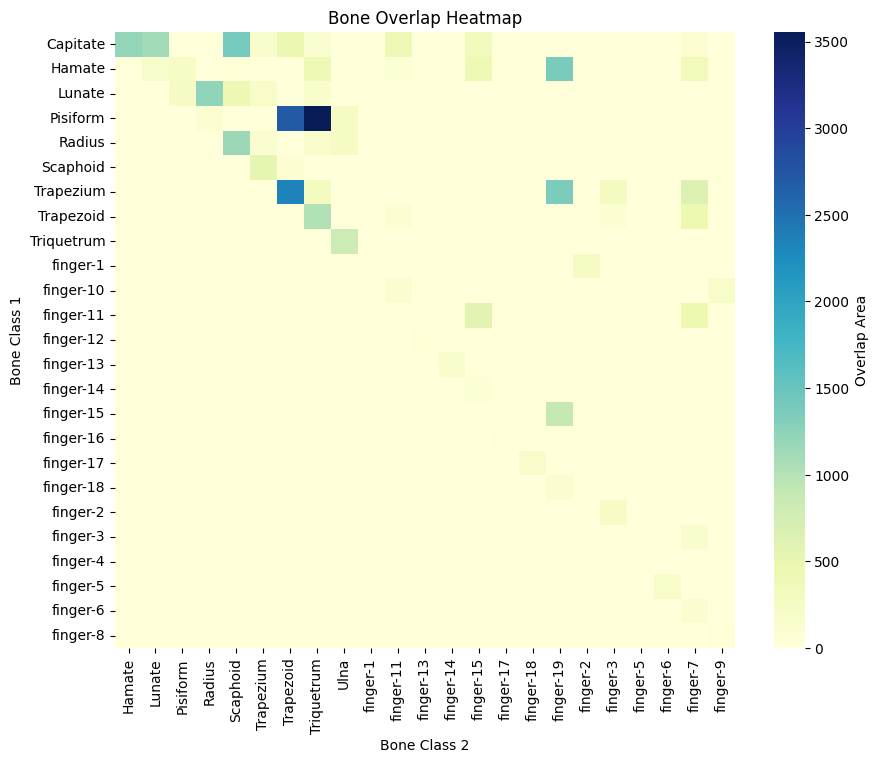

In [10]:
# 겹치는 뼈 행렬을 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_pivot, annot=False, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Overlap Area'})
plt.title("Bone Overlap Heatmap")
plt.xlabel("Bone Class 2")
plt.ylabel("Bone Class 1")
plt.show()


### 3개 이상 겹치는 클래스 분석

In [13]:
from collections import defaultdict


# 3개 이상의 클래스가 겹치는 경우를 분석하는 함수
def analyze_multiple_class_overlap(image_path, annotation_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    
    class_masks = {}

    # 각 클래스에 대해 마스크 생성
    for bone in data['annotations']:
        label = bone['label']
        mask = np.zeros_like(image, dtype=np.uint8)
        
        # 폴리곤 좌표를 사용하여 마스크 생성
        cv2.fillPoly(mask, [np.array(bone['points'], dtype=np.int32)], 1)
        class_masks[label] = mask

    # 모든 클래스 마스크를 쌓아서 겹치는 픽셀 계산
    stacked_mask = np.zeros_like(image, dtype=np.uint8)
    for mask in class_masks.values():
        stacked_mask += mask

    # 3개 이상의 클래스가 겹치는 픽셀 위치 찾기
    overlap_class_combinations = defaultdict(int)
    overlap_pixels = np.where(stacked_mask >= 3)  # 3개 이상의 클래스가 겹치는 위치

    # 3개 이상의 클래스가 겹치는 픽셀에 포함된 클래스 조합 계산
    for y, x in zip(*overlap_pixels):
        overlapping_classes = [label for label, mask in class_masks.items() if mask[y, x] == 1]
        overlapping_classes.sort()  # 조합을 일정하게 유지하기 위해 정렬
        if len(overlapping_classes) >= 3:
            overlap_class_combinations[tuple(overlapping_classes)] += 1

    return overlap_class_combinations

# 모든 이미지에 대해 결과 수집
all_overlap_results = defaultdict(int)
for image_path, ann_path in zip(image_paths, annotation_paths):
    overlap_results = analyze_multiple_class_overlap(image_path, ann_path)
    for classes, count in overlap_results.items():
        all_overlap_results[classes] += count

# 데이터프레임으로 변환하여 출력
overlap_df = pd.DataFrame(list(all_overlap_results.items()), columns=["Class Combination", "Count"])
overlap_df = overlap_df.sort_values(by="Count", ascending=False)
print(overlap_df)

                             Class Combination  Count
1               (Hamate, finger-15, finger-19)  61180
0                 (Capitate, Lunate, Scaphoid)  47761
3             (Trapezium, Trapezoid, finger-7)  41166
5                (Capitate, Hamate, finger-15)  25097
10            (Capitate, finger-11, finger-15)  23300
4                   (Lunate, Radius, Scaphoid)  14188
11              (Hamate, Pisiform, Triquetrum)  13780
2              (Trapezium, finger-3, finger-7)   6381
7               (Lunate, Pisiform, Triquetrum)   6030
16             (Capitate, Trapezoid, finger-7)   3294
8             (Scaphoid, Trapezium, Trapezoid)   2262
14             (Capitate, finger-11, finger-7)   1864
6                   (Capitate, Hamate, Lunate)   1594
18            (Capitate, Trapezium, Trapezoid)   1250
12              (Capitate, Hamate, Triquetrum)    921
9              (Capitate, Scaphoid, Trapezoid)    761
17               (Capitate, Hamate, finger-11)    748
15              (Hamate, fin

/tmp/ipykernel_1224280/3103497912.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_classes))  # 다양한 색상 선택을 위해 tab20 컬러맵 사용
/tmp/ipykernel_1224280/3103497912.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


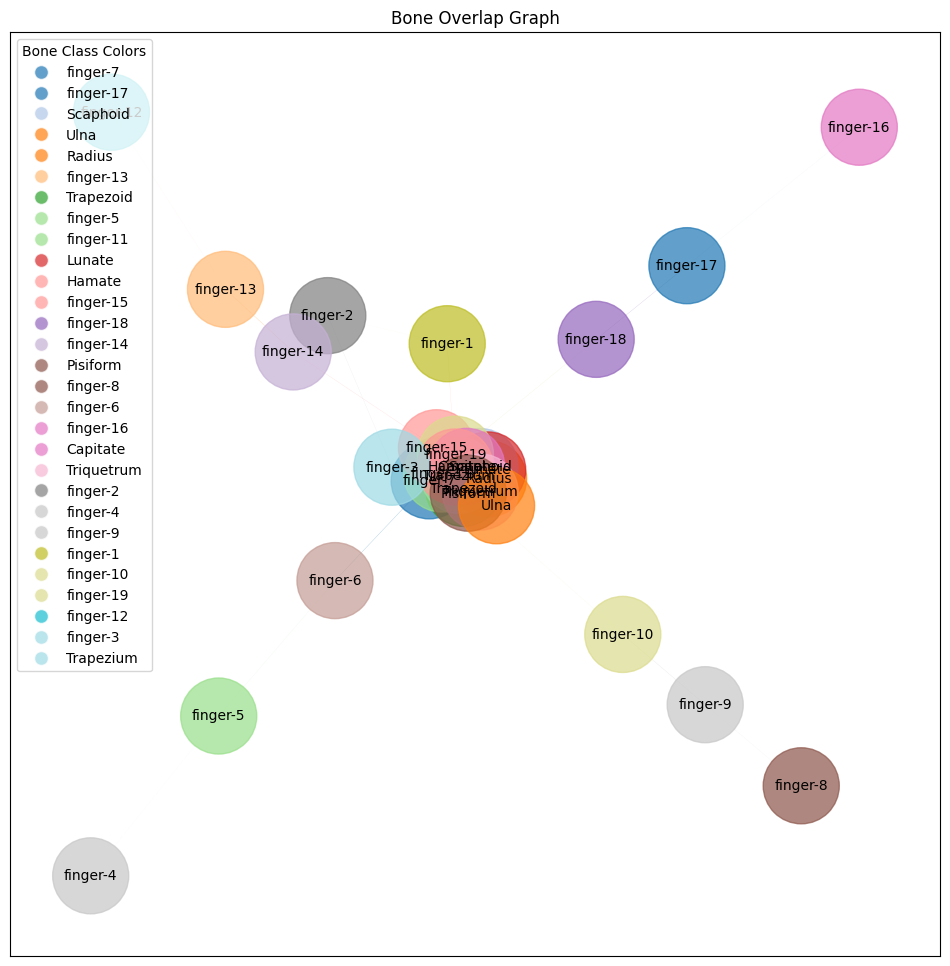

In [ ]:
# 보기 안좋음, 사용 안함

# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
# import numpy as np

# # 클래스마다 고유한 색상을 정의
# class_colors = {}
# unique_classes = list(set(overlap_df['Class1']).union(set(overlap_df['Class2'])))
# color_map = plt.cm.get_cmap('tab20', len(unique_classes))  # 다양한 색상 선택을 위해 tab20 컬러맵 사용
# for idx, cls in enumerate(unique_classes):
#     class_colors[cls] = color_map(idx)

# # 그래프 생성 및 엣지 추가
# G = nx.Graph()
# for _, row in overlap_df.iterrows():
#     if row['Overlap Area'] > 0:
#         G.add_edge(row['Class1'], row['Class2'], weight=row['Overlap Area'])

# # 노드 위치 설정
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G, k=0.5, seed=42)

# # 엣지 두께 및 색상 설정 (첫 번째 노드의 색상 사용)
# weights = [G[u][v]['weight'] / 100 for u, v in G.edges()]
# edge_colors = [class_colors[u] for u, v in G.edges()]
# nx.draw_networkx_edges(
#     G, pos, edge_color=edge_colors, width=weights, alpha=0.5
# )

# # 노드 색상 및 투명도 설정
# node_colors = [class_colors[node] for node in G.nodes()]
# nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, alpha=0.7)
# nx.draw_networkx_labels(G, pos, font_size=10)

# # 범례 추가 (클래스-색 매핑)
# legend_elements = [Line2D([0], [0], marker='o', color='w', label=cls,
#                           markerfacecolor=class_colors[cls], markersize=10, alpha=0.7)
#                    for cls in unique_classes]
# plt.legend(handles=legend_elements, loc="upper left", title="Bone Class Colors")

# plt.title("Bone Overlap Graph")
# plt.show()


### 왼손 Flip 한 이미지와 오른손 비교

Mean Squared Error (MSE): 91.5676338672638
Structural Similarity Index (SSIM): 0.3626859892050738


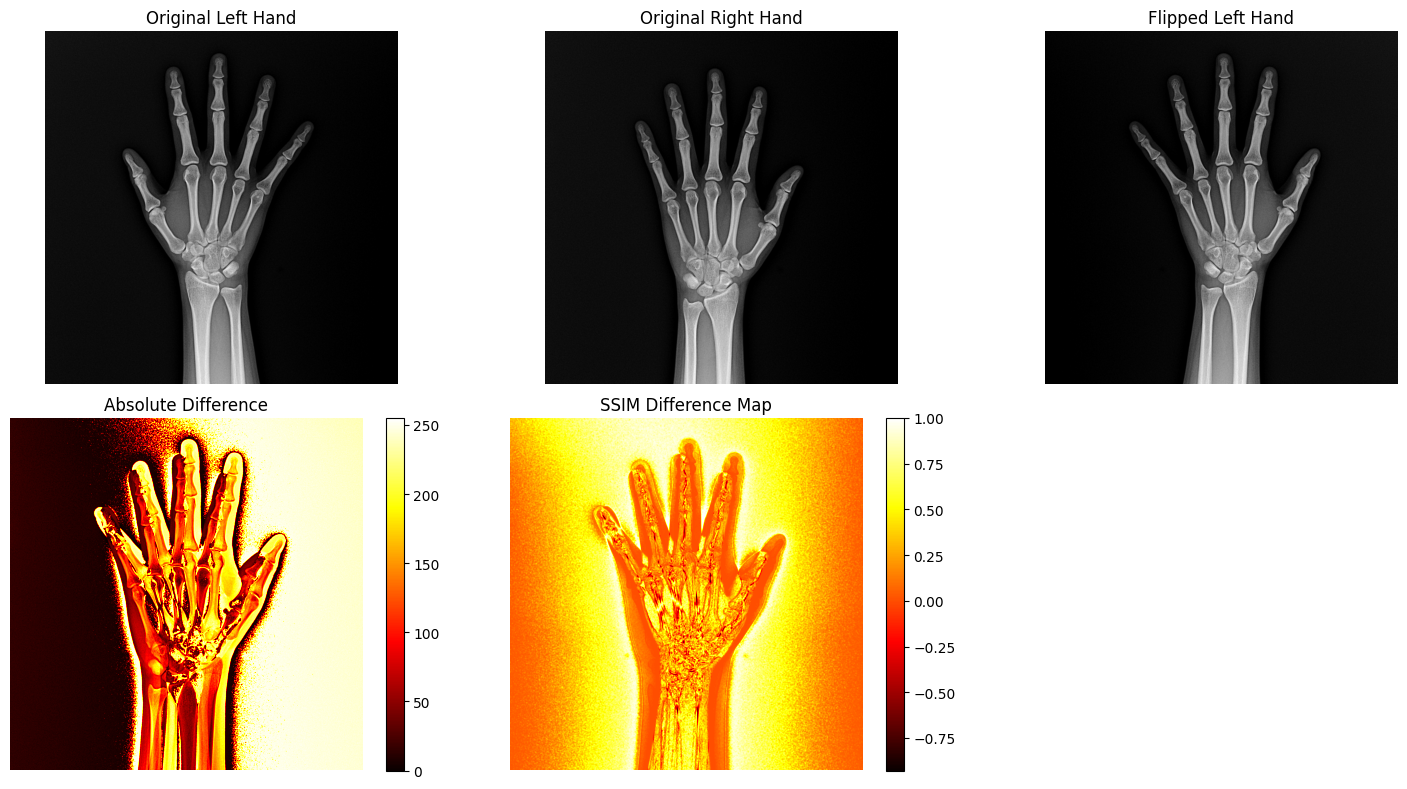

In [17]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# 두 이미지 간 MSE 및 SSIM 계산 함수
def calculate_similarity(image1, image2):
    # Mean Squared Error (MSE)
    mse_value = mean_squared_error(image1.ravel(), image2.ravel())
    
    # Structural Similarity Index (SSIM)
    ssim_value, diff = ssim(image1, image2, full=True)
    return mse_value, ssim_value, diff

# 시각적 비교 및 분석 함수
def visualize_comparison(left_image, right_image, flipped_left_image, diff):
    plt.figure(figsize=(15, 8))
    
    # 왼손 이미지
    plt.subplot(2, 3, 1)
    plt.imshow(left_image, cmap='gray')
    plt.title("Original Left Hand")
    plt.axis('off')

    # 오른손 이미지
    plt.subplot(2, 3, 2)
    plt.imshow(right_image, cmap='gray')
    plt.title("Original Right Hand")
    plt.axis('off')

    # 플립된 왼손 이미지
    plt.subplot(2, 3, 3)
    plt.imshow(flipped_left_image, cmap='gray')
    plt.title("Flipped Left Hand")
    plt.axis('off')

    # 차이 이미지 (절대 값 차이)
    plt.subplot(2, 3, 4)
    plt.imshow(np.abs(right_image - flipped_left_image), cmap='hot')
    plt.title("Absolute Difference")
    plt.colorbar()
    plt.axis('off')

    # SSIM 차이 이미지
    plt.subplot(2, 3, 5)
    plt.imshow(diff, cmap='hot')
    plt.title("SSIM Difference Map")
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 왼손-오른손 이미지 유사성 비교 함수
def compare_left_right_hands(left_hand_path, right_hand_path):
    # 이미지 로드 및 전처리
    left_image = cv2.imread(left_hand_path, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_hand_path, cv2.IMREAD_GRAYSCALE)

    # 이미지 크기를 맞추기
    if left_image.shape != right_image.shape:
        right_image = cv2.resize(right_image, (left_image.shape[1], left_image.shape[0]))

    # 왼손 이미지를 수평 플립
    flipped_left_image = cv2.flip(left_image, 1)

    # 유사도 계산
    mse_value, ssim_value, diff = calculate_similarity(flipped_left_image, right_image)
    
    # 결과 출력
    print(f"Mean Squared Error (MSE): {mse_value}")
    print(f"Structural Similarity Index (SSIM): {ssim_value}")
    
    # 시각화
    visualize_comparison(left_image, right_image, flipped_left_image, diff)

# 예제 실행
left_hand_image_path = "/data/ephemeral/home/data/train/DCM/ID001/image1661130828152_R.png"  # 왼손 이미지 경로
right_hand_image_path = "/data/ephemeral/home/data/train/DCM/ID001/image1661130891365_L.png"  # 오른손 이미지 경로

compare_left_right_hands(left_hand_image_path, right_hand_image_path)

In [ ]:
# # 데이터 로드
# submission = pd.read_csv("/data/ephemeral/home/jseo/val.csv")
# ground_truth = pd.read_csv("path_to_ground_truth.csv")

# # 예제 데이터가 주어졌다고 가정: id, class, x, y, width, height
# # 예: id, class, x, y, width, height (bounding box 형태)

# # 데이터프레임 정렬
# submission = submission.sort_values(by="id").reset_index(drop=True)
# ground_truth = ground_truth.sort_values(by="id").reset_index(drop=True)

# # 시각화 함수
# def visualize_differences(submission, ground_truth):
#     ids = submission['id'].unique()
#     for img_id in ids:
#         # 이미지와 예측, GT 데이터를 필터링
#         sub_data = submission[submission['id'] == img_id]
#         gt_data = ground_truth[ground_truth['id'] == img_id]

#         # 이미지 로드 (실제 경로 필요)
#         img_path = f"path_to_images/{img_id}.jpg"  # 이미지 경로 설정
#         image = cv2.imread(img_path)
#         if image is None:
#             print(f"Image {img_id} not found.")
#             continue
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # 이미지 시각화
#         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#         ax.imshow(image)
        
#         # GT 박스 (녹색)
#         for _, row in gt_data.iterrows():
#             x, y, w, h = row['x'], row['y'], row['width'], row['height']
#             rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none', label="Ground Truth")
#             ax.add_patch(rect)
        
#         # Submission 박스 (빨간색)
#         for _, row in sub_data.iterrows():
#             x, y, w, h = row['x'], row['y'], row['width'], row['height']
#             rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none', label="Prediction")
#             ax.add_patch(rect)
        
#         # 중복되는 범례 제거
#         handles, labels = ax.get_legend_handles_labels()
#         by_label = dict(zip(labels, handles))
#         ax.legend(by_label.values(), by_label.keys())

#         plt.title(f"Comparison for Image {img_id}")
#         plt.axis('off')
#         plt.show()

# # 실행
# visualize_differences(submission, ground_truth)

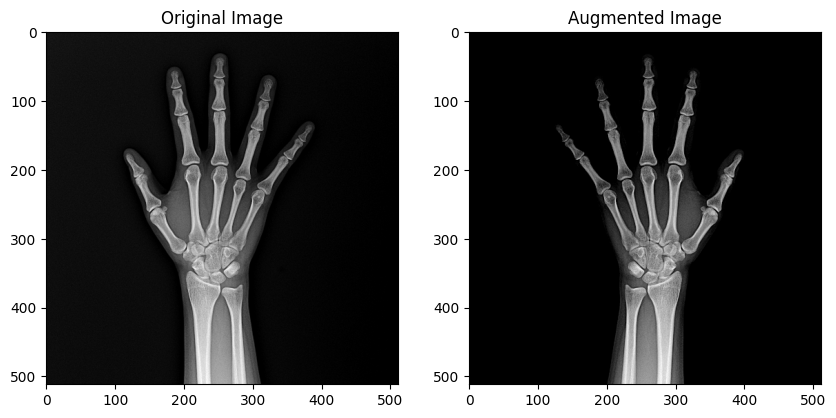

In [ ]:

# Define data augmentation pipeline
augmentation = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=30, p=0.5),
    RandomBrightnessContrast(p=0.5),
])

def augment_and_display(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512))
    augmented_image = augmentation(image=image)['image']

    # Display original and augmented images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(augmented_image, cmap='gray')
    axes[1].set_title("Augmented Image")
    plt.show()

# Show augmentation example
augment_and_display(image_paths[0])
